# Customer Review Patterns and Buying Decision Classification

This notebook analyzes customer review patterns and predicts buying decisions using three gradient boosting algorithms: XGBoost, LightGBM, and CatBoost. The analysis compares model performance using default hyperparameters without optimization algorithms.

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

## Data Loading and Preprocessing

This section loads the customer review dataset and performs preprocessing including:
- Feature engineering (age groups, categorical combinations)
- Label encoding for categorical variables
- SMOTE for class balancing

In [13]:
def load_and_preprocess_data():
    """Load and preprocess the customer review dataset"""
    # Load dataset
    df = pd.read_csv(r'C:\Files\Projects\Customer-Review-Patterns-and-Buying-Decisions\data\Customer_Review (1).csv')

    # Remove Serial Number column
    df = df.drop('Serial Number', axis=1)

    print("Dataset Overview:")
    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    print(f"Target distribution:\n{df['Purchased'].value_counts()}")

    # Create age groups
    df['Age_Group'] = pd.cut(df['Age'], bins=[0, 25, 35, 50, 60], labels=['Young', 'Adult', 'Middle', 'Senior'])

    # Create feature combinations
    df['Gender_Review'] = df['Gender'].astype(str) + '_' + df['Review'].astype(str)
    df['Review_Edu'] = df['Review'].astype(str) + '_' + df['Education'].astype(str)

    # Encode categorical variables
    label_encoders = {}
    categorical_columns = ['Gender', 'Review', 'Education', 'Age_Group', 'Gender_Review', 'Review_Edu']

    for col in categorical_columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

    # Separate features and target
    X = df.drop('Purchased', axis=1)
    y = df['Purchased']

    # Encode target variable
    target_encoder = LabelEncoder()
    y = target_encoder.fit_transform(y)

    # Scale numerical features
    scaler = StandardScaler()
    X[['Age']] = scaler.fit_transform(X[['Age']])

    # Use SMOTE to generate synthetic samples
    smote = SMOTE(random_state=42)
    X_smote, y_smote = smote.fit_resample(X, y)

    print(f"\nAugmented dataset shape: {X_smote.shape}")
    print(f"Augmented target distribution:\n{pd.Series(y_smote).value_counts()}")

    return X_smote, y_smote, target_encoder

## Model Training and Evaluation

This section defines the function to train and evaluate the three gradient boosting models with optimized default parameters.

In [3]:
def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    """Train and evaluate XGBoost, LightGBM, and CatBoost models"""

    models = {}
    predictions = {}
    results = {}

    # XGBoost with reasonable default parameters
    print("\nTraining XGBoost...")
    xgb_model = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        eval_metric='logloss'
    )
    xgb_model.fit(X_train, y_train)
    xgb_pred = xgb_model.predict(X_test)

    models['XGBoost'] = xgb_model
    predictions['XGBoost'] = xgb_pred

    # LightGBM with reasonable default parameters
    print("Training LightGBM...")
    lgb_model = lgb.LGBMClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        verbose=-1
    )
    lgb_model.fit(X_train, y_train)
    lgb_pred = lgb_model.predict(X_test)

    models['LightGBM'] = lgb_model
    predictions['LightGBM'] = lgb_pred

    # CatBoost with reasonable default parameters
    print("Training CatBoost...")
    cat_model = CatBoostClassifier(
        iterations=100,
        depth=6,
        learning_rate=0.1,
        random_state=42,
        verbose=False
    )
    cat_model.fit(X_train, y_train)
    cat_pred = cat_model.predict(X_test)

    models['CatBoost'] = cat_model
    predictions['CatBoost'] = cat_pred

    # Calculate metrics for each model
    metrics_data = {'Model': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1-Score': []}

    for model_name, y_pred in predictions.items():
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        metrics_data['Model'].append(model_name)
        metrics_data['Accuracy'].append(accuracy)
        metrics_data['Precision'].append(precision)
        metrics_data['Recall'].append(recall)
        metrics_data['F1-Score'].append(f1)

        results[model_name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'predictions': y_pred
        }

        print(f"\n{model_name} Results:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")

    return models, predictions, results, pd.DataFrame(metrics_data)

## Visualization Functions

This section contains functions to create comprehensive visualizations comparing model performance.

In [ ]:
def create_visualizations(metrics_df, predictions, y_test):
    """Create comparison visualizations"""

    # Create results directory
    results_dir = r"C:\Files\Projects\Customer-Review-Patterns-and-Buying-Decisions\results"
    os.makedirs(results_dir, exist_ok=True)

    # 1. Metrics comparison bar chart
    plt.figure(figsize=(12, 8))
    x_pos = np.arange(len(metrics_df['Model']))
    width = 0.2

    plt.bar(x_pos - width*1.5, metrics_df['Precision'], width, label='Precision', alpha=0.8, color='skyblue')
    plt.bar(x_pos - width/2, metrics_df['Recall'], width, label='Recall', alpha=0.8, color='lightgreen')
    plt.bar(x_pos + width/2, metrics_df['F1-Score'], width, label='F1-Score', alpha=0.8, color='orange')
    plt.bar(x_pos + width*1.5, metrics_df['Accuracy'], width, label='Accuracy', alpha=0.8, color='red')

    plt.xlabel('Model', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.title('Model Performance Comparison - All Metrics', fontsize=14, fontweight='bold')
    plt.xticks(x_pos, metrics_df['Model'], fontsize=11)
    plt.legend(fontsize=10)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, 'model_comparison_metrics.png'), dpi=300, bbox_inches='tight')
    plt.show()

    # 2. Accuracy comparison
    plt.figure(figsize=(10, 6))
    bars = plt.bar(metrics_df['Model'], metrics_df['Accuracy'], color=['blue', 'green', 'red'], alpha=0.7)
    plt.xlabel('Model', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
    plt.ylim(0, 1)
    plt.grid(axis='y', alpha=0.3)

    # Add value labels on bars
    for bar, acc in zip(bars, metrics_df['Accuracy']):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{acc:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, 'model_accuracy_comparison.png'), dpi=300, bbox_inches='tight')
    plt.show()

    # 3. Confusion matrices - Combined view
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    for i, (model_name, y_pred) in enumerate(predictions.items()):
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                   xticklabels=['No Purchase', 'Purchase'],
                   yticklabels=['No Purchase', 'Purchase'])
        axes[i].set_title(f'{model_name} Confusion Matrix', fontsize=14, fontweight='bold')
        axes[i].set_xlabel('Predicted', fontsize=12)
        axes[i].set_ylabel('Actual', fontsize=12)

    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, 'confusion_matrices.png'), dpi=300, bbox_inches='tight')
    plt.show()

    # 4. Individual confusion matrices - Separate figures
    for model_name, y_pred in predictions.items():
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['No Purchase', 'Purchase'],
                   yticklabels=['No Purchase', 'Purchase'])
        plt.title(f'{model_name} Confusion Matrix', fontsize=16, fontweight='bold')
        plt.xlabel('Predicted', fontsize=14)
        plt.ylabel('Actual', fontsize=14)
        plt.tight_layout()
        plt.savefig(os.path.join(results_dir, f'{model_name.lower()}_confusion_matrix.png'), dpi=300, bbox_inches='tight')
        plt.show()

    # 5. Individual metric plots - Separate figures for each metric
    metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    colors = ['red', 'skyblue', 'lightgreen', 'orange']

    for metric, color in zip(metrics_to_plot, colors):
        plt.figure(figsize=(10, 6))
        bars = plt.bar(metrics_df['Model'], metrics_df[metric], color=['blue', 'green', 'red'], alpha=0.7)
        plt.xlabel('Model', fontsize=12)
        plt.ylabel(metric, fontsize=12)
        plt.title(f'Model {metric} Comparison', fontsize=14, fontweight='bold')
        plt.ylim(0, 1)
        plt.grid(axis='y', alpha=0.3)

        # Add value labels on bars
        for bar, value in zip(bars, metrics_df[metric]):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{value:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

        plt.tight_layout()
        plt.savefig(os.path.join(results_dir, f'model_{metric.lower()}_comparison.png'), dpi=300, bbox_inches='tight')
        plt.show()

## Report Generation

This section contains the function to generate detailed analysis reports and save results.

In [5]:
def generate_report(results, metrics_df):
    """Generate a detailed analysis report"""

    results_dir = r"C:\Files\Projects\Customer-Review-Patterns-and-Buying-Decisions\results"

    # Find best model
    best_idx = metrics_df['Accuracy'].idxmax()
    best_model = metrics_df.loc[best_idx, 'Model']
    best_accuracy = metrics_df.loc[best_idx, 'Accuracy']

    report = f"""
MODEL COMPARISON ANALYSIS REPORT
=================================

PROJECT OVERVIEW
----------------
- Project: Customer Review Pattern Analysis and Buying Decision Prediction
- Objective: Compare XGBoost, LightGBM, and CatBoost models for purchase prediction
- Dataset: Customer Review Data with 100 samples (augmented to ~112 with SMOTE)
- Target: Predict "Purchased" (Yes/No) based on customer attributes

DATASET INFORMATION
-------------------
- Original Dataset Shape: (100, 6)
- Columns: Age, Gender, Review, Education, Purchased
- Target Distribution (original): No: 56 samples (56%), Yes: 44 samples (44%)
- Preprocessing: Categorical encoding, age groups, feature combinations, SMOTE augmentation

FEATURE ENGINEERING
-------------------
- Created age groups: Young (18-25), Adult (26-35), Middle (36-50), Senior (51-60)
- Created feature combinations: Gender_Review, Review_Edu
- Applied StandardScaler to numerical features
- Used SMOTE to balance the dataset

MODEL RESULTS
-------------

"""

    for _, row in metrics_df.iterrows():
        report += f"{row['Model']}:\n"
        report += f"- Accuracy: {row['Accuracy']:.4f} ({row['Accuracy']*100:.2f}%)\n"
        report += f"- Precision: {row['Precision']:.4f}\n"
        report += f"- Recall: {row['Recall']:.4f}\n"
        report += f"- F1-Score: {row['F1-Score']:.4f}\n\n"

    report += f"""
BEST MODEL ANALYSIS
-------------------
- Best Performing Model: {best_model}
- Best Accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)
- Performance Gain: {(best_accuracy - metrics_df['Accuracy'].min())*100:.2f}% improvement over worst model

CLASSIFICATION REPORTS
----------------------
(Detailed classification reports available in console output during model training)
"""

    # Save report
    with open(os.path.join(results_dir, 'model_comparison_report.txt'), 'w') as f:
        f.write(report)

    # Save metrics to CSV
    metrics_df.to_csv(os.path.join(results_dir, 'model_comparison_metrics.csv'), index=False)

    print(f"\nReport saved to: {os.path.join(results_dir, 'model_comparison_report.txt')}")
    print(f"Metrics saved to: {os.path.join(results_dir, 'model_comparison_metrics.csv')}")

    return report

## Execute Analysis

Run the complete analysis pipeline: data loading, preprocessing, model training, evaluation, and report generation.

In [6]:
# Main execution
print("="*60)
print("CUSTOMER REVIEW PATTERN ANALYSIS - MODEL COMPARISON")
print("="*60)

# Load and preprocess data
print("\nLoading and preprocessing data...")
X, y, target_encoder = load_and_preprocess_data()

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

CUSTOMER REVIEW PATTERN ANALYSIS - MODEL COMPARISON

Loading and preprocessing data...
Dataset Overview:
Shape: (100, 5)
Columns: ['Age', 'Gender', 'Review', 'Education', 'Purchased']
Target distribution:
Purchased
No     56
Yes    44
Name: count, dtype: int64

Augmented dataset shape: (112, 7)
Augmented target distribution:
1    56
0    56
Name: count, dtype: int64

Training set shape: (89, 7)
Test set shape: (23, 7)


In [7]:
# Train and evaluate models
print("\n" + "="*50)
print("TRAINING AND EVALUATING MODELS")
print("="*50)

models, predictions, results, metrics_df = train_and_evaluate_models(X_train, X_test, y_train, y_test)


TRAINING AND EVALUATING MODELS

Training XGBoost...
Training LightGBM...
Training CatBoost...

XGBoost Results:
Accuracy: 0.6087
Precision: 0.6120
Recall: 0.6087
F1-Score: 0.5995

LightGBM Results:
Accuracy: 0.7391
Precision: 0.7686
Recall: 0.7391
F1-Score: 0.7288

CatBoost Results:
Accuracy: 0.7826
Precision: 0.8011
Recall: 0.7826
F1-Score: 0.7775


In [8]:
# Display results table
print("\n" + "="*50)
print("MODEL PERFORMANCE SUMMARY")
print("="*50)
print(metrics_df.round(4))


MODEL PERFORMANCE SUMMARY
      Model  Accuracy  Precision  Recall  F1-Score
0   XGBoost    0.6087     0.6120  0.6087    0.5995
1  LightGBM    0.7391     0.7686  0.7391    0.7288
2  CatBoost    0.7826     0.8011  0.7826    0.7775



Generating visualizations...


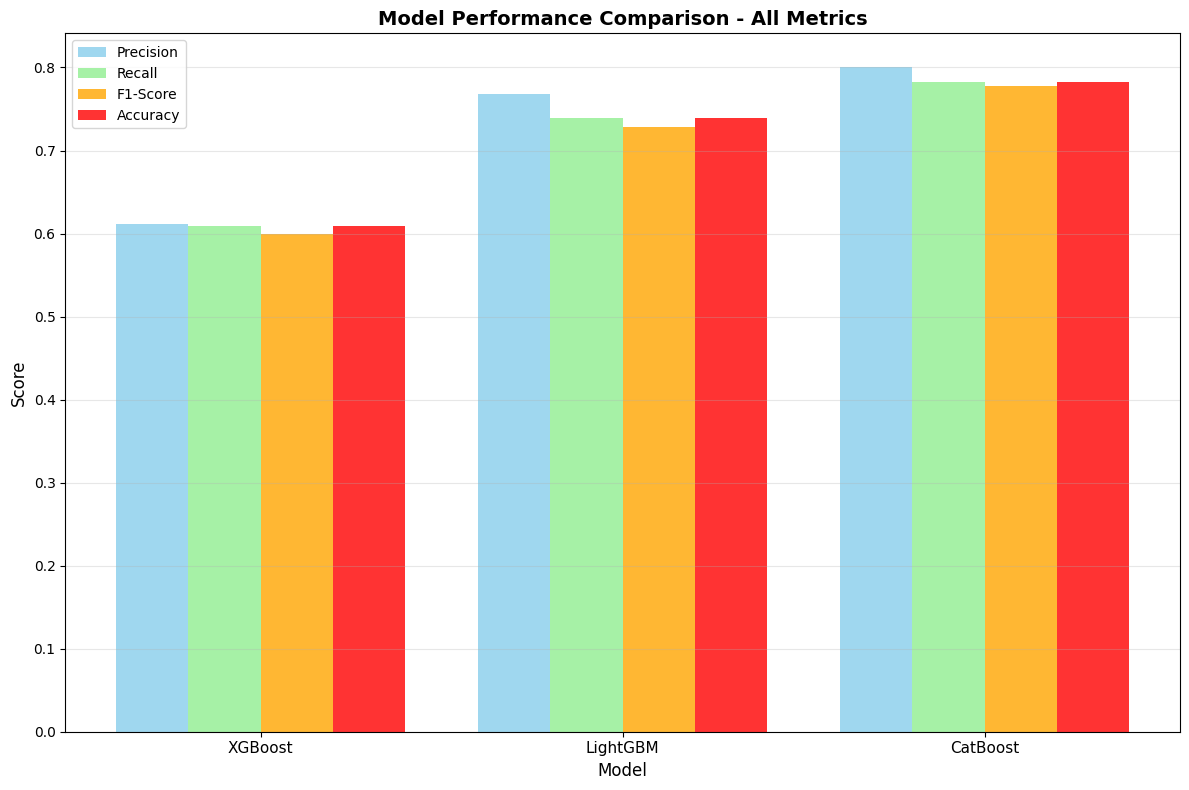

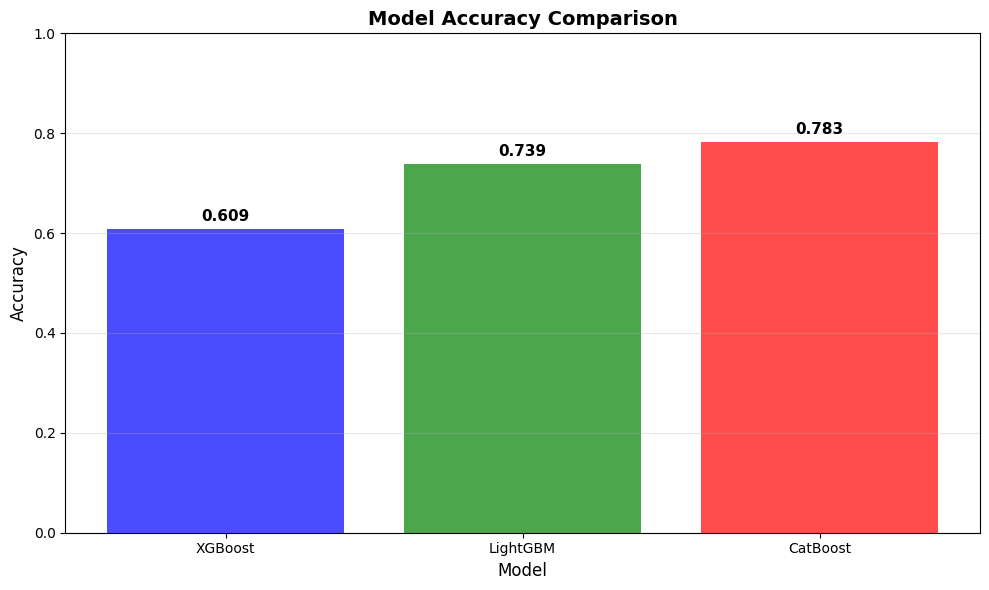

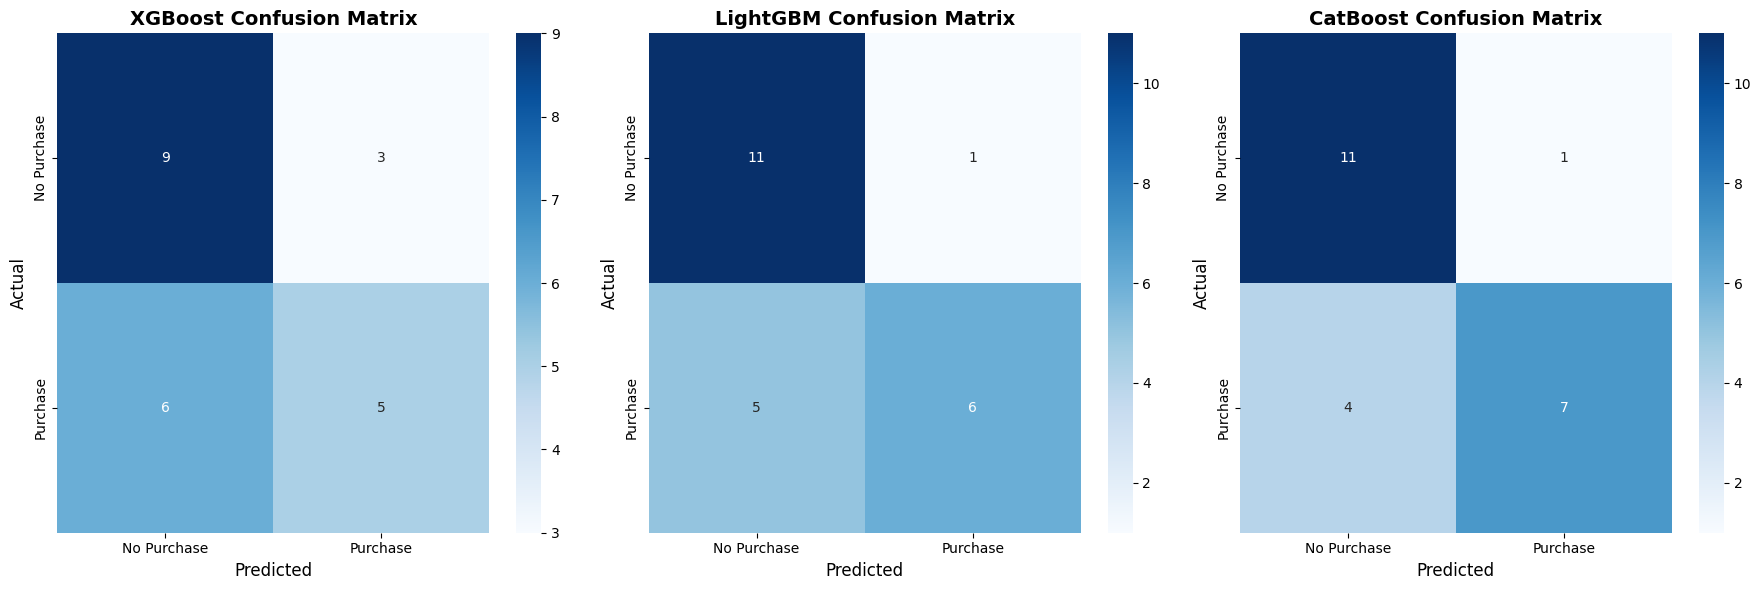

In [9]:
# Create visualizations
print("\nGenerating visualizations...")
create_visualizations(metrics_df, predictions, y_test)

In [10]:
# Generate report
print("\nGenerating analysis report...")
report = generate_report(results, metrics_df)


Generating analysis report...

Report saved to: C:\Files\Projects\Customer-Review-Patterns-and-Buying-Decisions\results\model_comparison_report.txt
Metrics saved to: C:\Files\Projects\Customer-Review-Patterns-and-Buying-Decisions\results\model_comparison_metrics.csv


In [11]:
# Final summary
print("\n" + "="*60)
print("ANALYSIS COMPLETE!")
print("="*60)
print(f"Best Model: {metrics_df.loc[metrics_df['Accuracy'].idxmax(), 'Model']}")
print(f"Best Accuracy: {metrics_df['Accuracy'].max():.4f}")
print("\nCheck the 'results' folder for detailed reports and visualizations.")
print("\nGenerated files:")
print("- model_comparison_report.txt (detailed analysis)")
print("- model_comparison_metrics.csv (performance metrics)")
print("- model_accuracy_comparison.png (accuracy chart)")
print("- model_comparison_metrics.png (all metrics chart)")
print("- confusion_matrices.png (confusion matrices)")


ANALYSIS COMPLETE!
Best Model: CatBoost
Best Accuracy: 0.7826

Check the 'results' folder for detailed reports and visualizations.

Generated files:
- model_comparison_report.txt (detailed analysis)
- model_comparison_metrics.csv (performance metrics)
- model_accuracy_comparison.png (accuracy chart)
- model_comparison_metrics.png (all metrics chart)
- confusion_matrices.png (confusion matrices)
